In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import random

import torch
import torch.nn as nn
from torch.nn import Parameter
#import torchoptics
#from torchoptics import System
#from torchoptics.elements import PhaseModulator
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from matplotlib.colors import hsv_to_rgb
import matplotlib.ticker as ticker

In [5]:
# Check if GPU is registered and being used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

devNumber = torch.cuda.current_device()
print(f"The current device number is {devNumber}")

dev_name = torch.cuda.get_device_name(devNumber)
print(f"GPU is {dev_name}")

Using Device: cuda
The current device number is 0
GPU is NVIDIA GeForce RTX 2060


In [6]:
# Make a vectorising function
def vectorise(field):
    x = field.shape[0]
    y = field.shape[1]
    return field.reshape(x*y,1)

# Make an unvectorising function
def unvectorise(field, dim):
    return field.reshape(dim,dim)

def Complex2HSV(z, rmin, rmax, hue_start=90):
    # get amplidude of z and limit to [rmin, rmax]
    amp = np.abs(z)
    amp = np.where(amp < rmin, rmin, amp)
    amp = np.where(amp > rmax, rmax, amp)
    ph = np.angle(z, deg=1)# + hue_start
    # HSV are values in range [0,1]
    h = (ph % 360) / 360
    s = 0.85 * np.ones_like(h)
    v = (amp -rmin) / (rmax - rmin)
    return hsv_to_rgb(np.dstack((h,s,v)))

def gaussian_torch(shape, mean, std):
    x, y = np.meshgrid(np.linspace(-1, 1, shape), np.linspace(-1, 1, shape))
    d = np.sqrt(x**2 + y**2)
    gaussian = np.exp(-((d - mean)**2 / (2.0 * std**2)))
    gaussian = torch.from_numpy(gaussian)
    return gaussian

# Make FFT functions
def fft2(field: torch.Tensor) -> torch.Tensor:
    """2D discrete forward fourier transform."""
    return torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(field)))

def ifft2(field: torch.Tensor) -> torch.Tensor:
    """2D discrete inverse fourier transform."""
    return torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(field)))

# Make a propagation function using these fft2 functions
def prop(field_in, kz, distance):
    """Propagation of a 2D field using the fft2 functions."""
    field_in_ft = fft2(field_in)
    field_out_ft = field_in_ft * torch.exp(1j*kz*distance)
    field_out = ifft2(field_out_ft)
    return field_out

In [7]:
class Field(torch.Tensor):
    """Class designed around a 2D electric field represented by a torch tensor."""
    wl = 700e-9 #[m]
    k = torch.tensor(2*np.pi/wl) #[1/m]
    k_x = 1235678
    k_y = 3457437
    k_z = (torch.abs(k)**2 - k_x**2 - k_y**2)**0.5 #[1/m]
    
    def __init__(self, tensor):
        self = tensor

    def normalise(self):
        return self / torch.linalg.matrix_norm(self)

    def visualise(self, figsize=(10,5),title=""):
        """Displays a visual plot of the field, using hsv colour mapping to demonstrate the 
        fields phase (Hue) and amplitude (Value)."""
        # Set up plots
        fig, axs = plt.subplots(1,2, figsize=figsize)

        # Plot the given field
        axs[0].imshow(Complex2HSV(self, 0, 0.065))

        # Colour bar
        V, H = np.mgrid[0:1:100j, 0:1:300j]
        S = np.ones_like(V)
        HSV = np.dstack((H,S,V))
        RGB = hsv_to_rgb(HSV)

        axs[1].imshow(RGB, origin="lower", extent=[0, 2*np.pi, 0, 1], aspect=15)

        axs[1].set_xticks([0, np.pi, 2*np.pi], ['0', '$\pi$', '$2\pi$'])
        axs[1].set_yticks([0, 1], ['0', '1'])

        axs[1].set_ylabel("Normalised Amplitude")
        axs[1].set_xlabel("Phase (rad.)")

        fig.show()

    # Make a propagation function using these fft2 functions
    def propagate(self, distance):
        """Propagation of a 2D field using the fft2 functions."""
        field_in_ft = fft2(self)
        field_out_ft = field_in_ft * torch.exp(1j*self.Kz*distance)
        field_out = ifft2(field_out_ft)
        return field_out

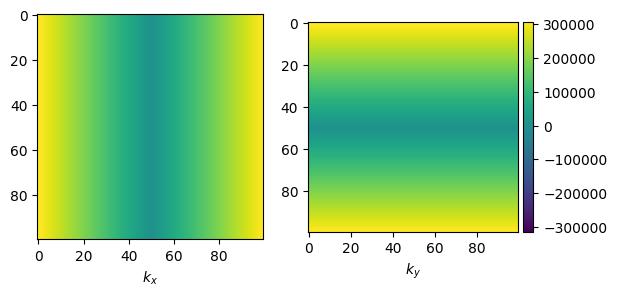

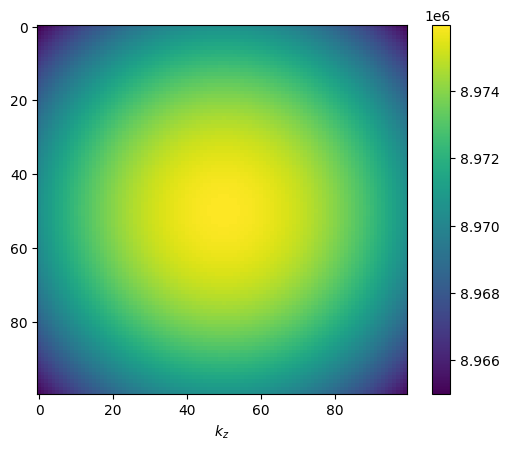

In [8]:
pix_size = 1e-5 #[m]
grid_size = 100 # Number of pixels per side of the grid
grid_length = pix_size * grid_size # Length of grid in real space coords
wl = 700e-9 #[m]
#print(grid_length)

Nx = np.linspace(-50,50,grid_size)
Ny = np.linspace(-50,50,grid_size)
X,Y = np.meshgrid(Nx,Ny)

# Make the Kx, Ky and Kz grids.
# Start with making arrays of the right size to append correct values onto later.
Kx = np.ones((grid_size,grid_size))
Ky = np.ones((grid_size,grid_size))

for y,i in zip(np.arange(-50,50,1), np.arange(0,101,1)):
    for x,j in zip(np.arange(-50,50,1), np.arange(0,101,1)):
        Kx[i,j] = (2*np.pi*x)/grid_length
        Ky[i,j] = (2*np.pi*y)/grid_length

fig, axs = plt.subplots(nrows=1, ncols=2)
minmin = np.min([np.min(Kx), np.min(Ky)])
maxmax = np.max([np.max(Kx), np.max(Ky)])

#im1 = axs[0].imshow(Kx, vmin=minmin, vmax=maxmax)
#im2 = axs[1].imshow(Ky, vmin=minmin, vmax=maxmax)
im1 = axs[0].imshow(np.abs(Kx), vmin=minmin, vmax=maxmax)
im2 = axs[1].imshow(np.abs(Ky), vmin=minmin, vmax=maxmax)

axs[0].set_xlabel("$k_x$")
axs[1].set_xlabel("$k_y$")

divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(im2, cax=cax)

Kz = torch.from_numpy(((2*np.pi/wl)**2 - Kx**2 - Ky**2)**0.5)#.type(torch.cfloat)
fig, ax = plt.subplots(1,1)
im1 = ax.imshow(Kz)
ax.set_xlabel("$k_z$")
fig.colorbar(im1)

C:\Users\elija\AppData\Local\Temp\ipykernel_11076\3006855479.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\elija\AppData\Local\Temp\ipykernel_11076\3006855479.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


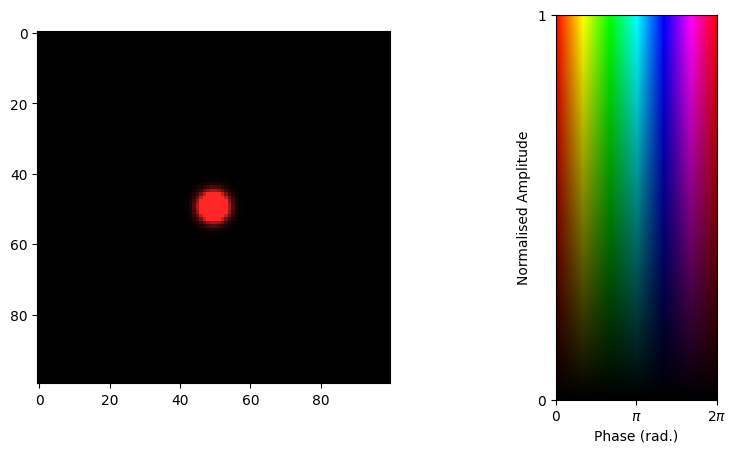

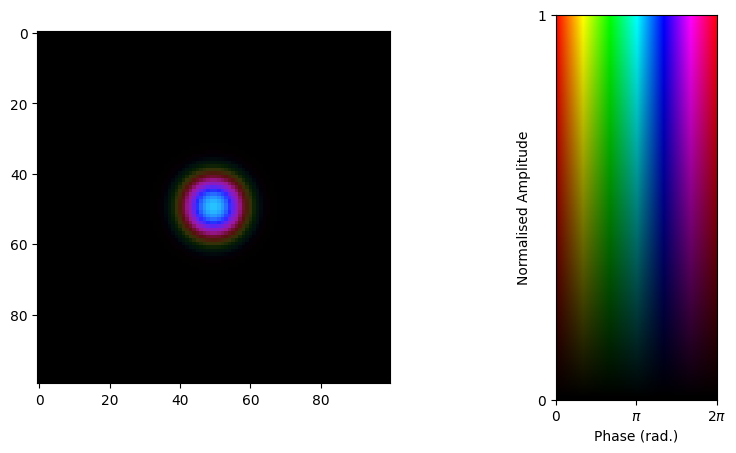

In [9]:
input_field = Field(gaussian_torch(100, 0, 0.05)).normalise().type(torch.cdouble)
input_field.visualise()

output_field = prop(input_field, Kz, 0.01)
output_field.visualise()

Text(0.5, 0, '$k_z$')

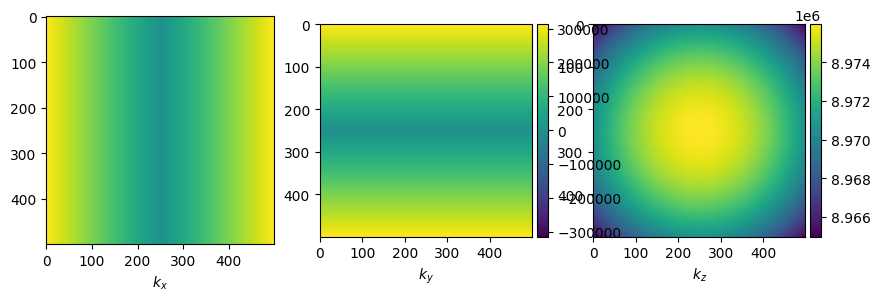

In [10]:
pix_size = 1e-5 #[m]
grid_size = 500 # Number of pixels per side of the grid
grid_length = pix_size * grid_size # Length of grid in real space coords
wl = 700e-9 #[m]
#print(grid_length)

Nx = np.arange(-grid_size/2,grid_size/2,1)
Ny = np.arange(-grid_size/2,grid_size/2,1)
X,Y = np.meshgrid(Nx,Ny)
X = torch.from_numpy(X)
Y = torch.from_numpy(Y)

alpha = torch.tensor(0.05)
beta = torch.tensor(0.05)

# Make the Kx, Ky and Kz grids.
# Start with making arrays of the right size to append correct values onto later.
Kx = np.ones((grid_size,grid_size))
Ky = np.ones((grid_size,grid_size))

for y,i in zip(np.arange(-grid_size/2,grid_size/2,1), np.arange(0,grid_size+1,1)):
    for x,j in zip(np.arange(-grid_size/2,grid_size/2,1), np.arange(0,grid_size+1,1)):
        Kx[i,j] = (2*np.pi*x)/grid_length
        Ky[i,j] = (2*np.pi*y)/grid_length

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
minmin = np.min([np.min(Kx), np.min(Ky)])
maxmax = np.max([np.max(Kx), np.max(Ky)])

#im1 = axs[0].imshow(Kx, vmin=minmin, vmax=maxmax)
#im2 = axs[1].imshow(Ky, vmin=minmin, vmax=maxmax)
im1 = axs[0].imshow(np.abs(Kx), vmin=minmin, vmax=maxmax)
im2 = axs[1].imshow(np.abs(Ky), vmin=minmin, vmax=maxmax)

axs[0].set_xlabel("$k_x$")
axs[1].set_xlabel("$k_y$")

divider1 = make_axes_locatable(axs[1])
divider2 = make_axes_locatable(axs[2])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(im2, cax=cax1)

Kz = torch.from_numpy(((2*np.pi/wl)**2 - Kx**2 - Ky**2)**0.5)#.type(torch.cfloat)

im3 = axs[2].imshow(Kz)
plt.colorbar(im3,cax=cax2)
axs[2].set_xlabel("$k_z$")

C:\Users\elija\AppData\Local\Temp\ipykernel_11076\3006855479.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\elija\AppData\Local\Temp\ipykernel_11076\3006855479.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


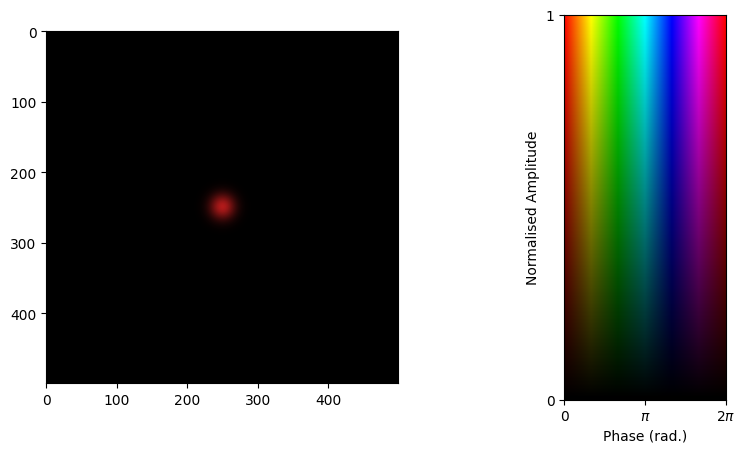

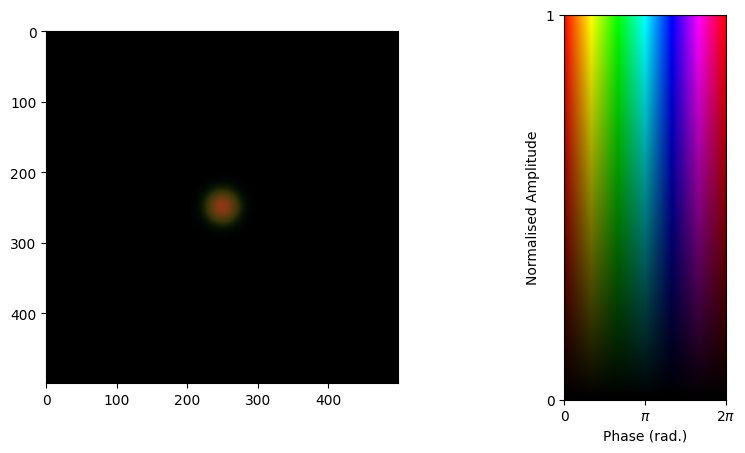

In [11]:
# Test the prop function
input_field = Field(gaussian_torch(500, 0, 0.05)).normalise().type(torch.cdouble)
input_field.visualise()

output_field = prop(input_field, Kz, 0.1)
output_field.visualise()

# Output gaussian is defocused and had altering phase as expected!! Note: Normalisation also seems to be preserved here.

In [12]:
# Make the tilt phase mask function
def tilt2d(field_in: torch.Tensor, X: torch.Tensor, Y: torch.Tensor, wl:float, alpha: float=0.0, beta: float=0.0) -> torch.Tensor:
    """Adds tilted phase to a 2D complex field."""
    tilt_phase = (-2*np.pi/wl)*(X*torch.sin(torch.deg2rad(torch.tensor(alpha))) + Y*torch.sin(torch.deg2rad(torch.tensor(beta))))
    field_out = field_in * torch.exp(1j*tilt_phase)
    #field_out = torch.abs(field_in) * torch.exp(1j*(tilt_phase+torch.angle(field_in)))
    return field_out

def tilt_phase_mask(X: torch.Tensor, Y: torch.Tensor, wl:float, alpha: float=0.0, beta: float=0.0) -> torch.Tensor:
    """Makes the tilt phase mask field, useful for plotting what the mask looks like."""
    return torch.exp(1j*(-2*np.pi/wl)*(X*torch.sin(torch.deg2rad(torch.tensor(alpha))) + Y*torch.sin(torch.deg2rad(torch.tensor(beta)))))

In [13]:
# Calculate acceptable values for alpha and beta
# sin(alpha) = Kx/K = 0.05
alpha_max = beta_max = torch.rad2deg(torch.asin(torch.tensor(0.05)))
alpha_max.item()

2.8659842014312744

C:\Users\elija\AppData\Local\Temp\ipykernel_11076\3006855479.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


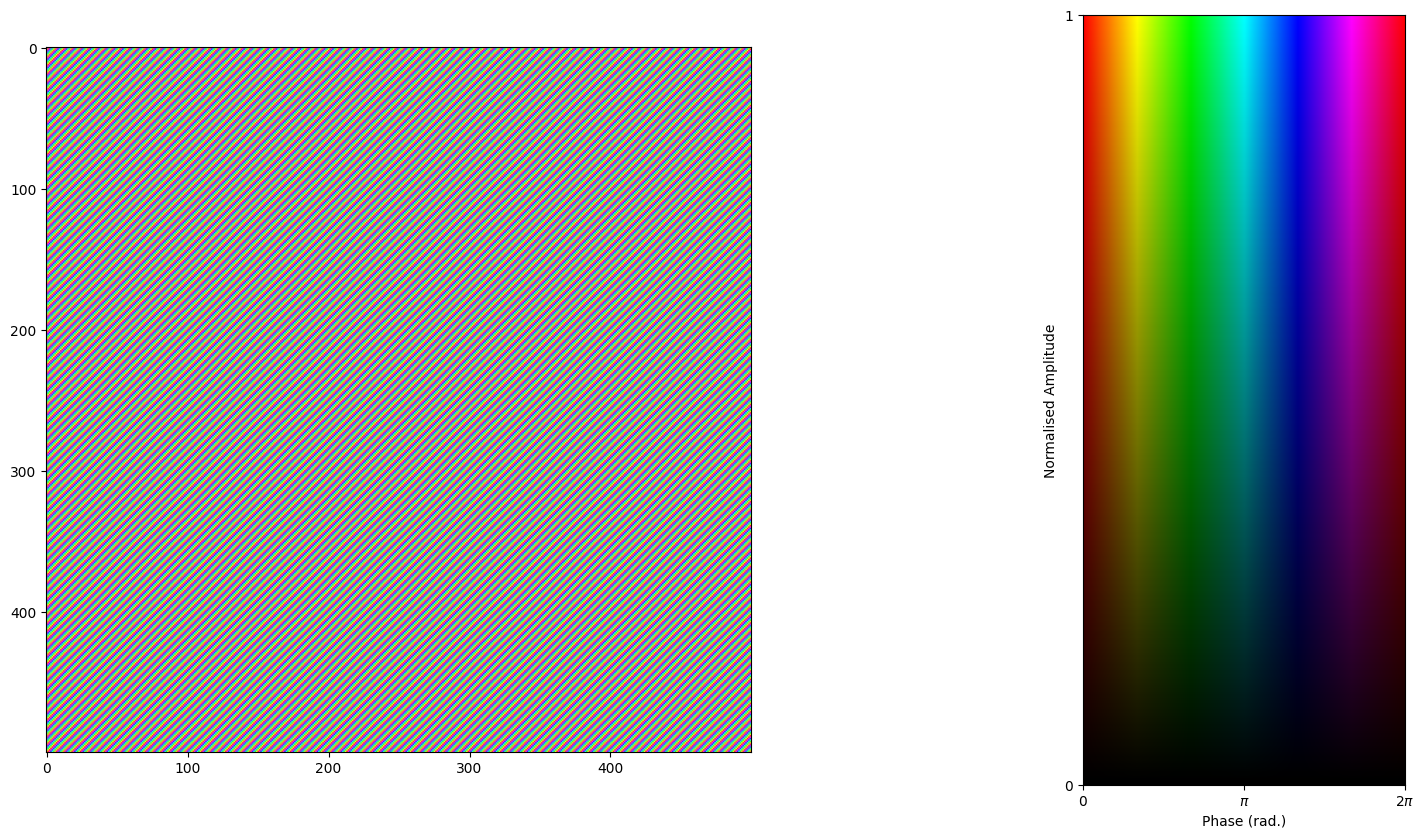

In [14]:
alpha = 0.7
beta = 0.7
Nx = np.arange(-grid_size/2,grid_size/2,1)
Ny = np.arange(-grid_size/2,grid_size/2,1)
X,Y = np.meshgrid(Nx,Ny)
X = torch.from_numpy(X)*pix_size
Y = torch.from_numpy(Y)*pix_size
tilt_mask = Field(tilt_phase_mask(X,Y,700e-9,alpha=alpha,beta=beta))
tilt_mask.visualise(figsize=(20,10))

C:\Users\elija\AppData\Local\Temp\ipykernel_11076\3006855479.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\elija\AppData\Local\Temp\ipykernel_11076\3006855479.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\elija\AppData\Local\Temp\ipykernel_11076\3006855479.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\elija\AppData\Local\Temp\ipykernel_11076\3006855479.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


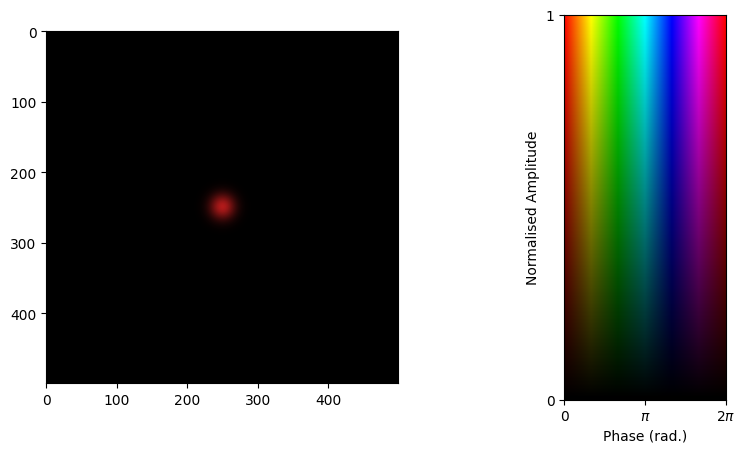

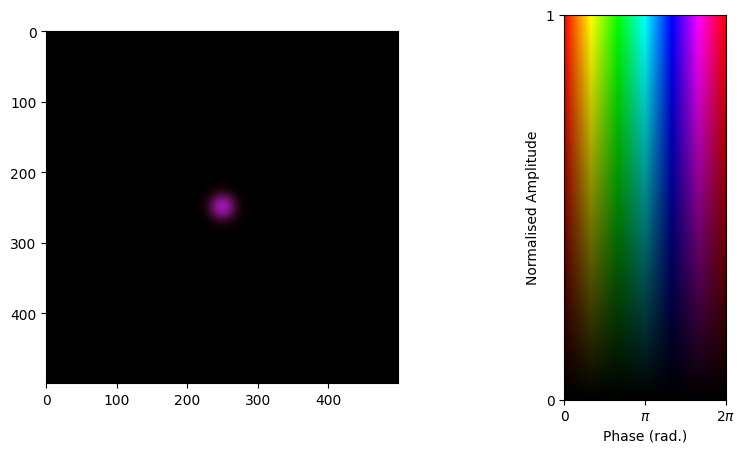

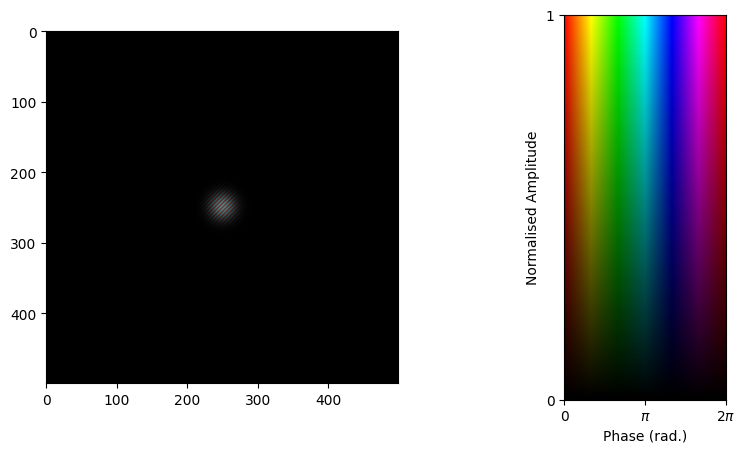

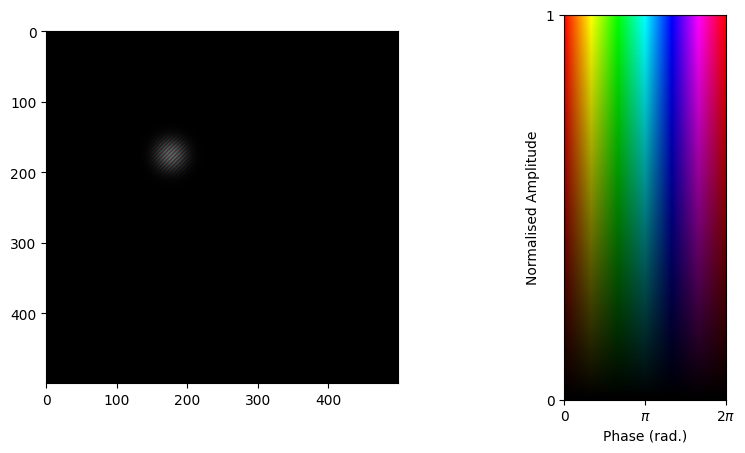

In [15]:
# Propagate a gaussian beam to the phase mask and further (Create data for model)
input_field = Field(gaussian_torch(500, 0, 0.05)).normalise().type(torch.cdouble)
input_field.visualise()
field_before_mask = prop(input_field, Kz, 0.04)
field_before_mask.visualise()
field_after_mask = tilt2d(field_before_mask,X,Y,700e-9,alpha=alpha, beta=beta)
field_after_mask.visualise()
output_field = prop(field_after_mask,Kz,0.06)
output_field.visualise()

In [16]:
# Construct a Frenel Lens
def frenel_lens_mask(X:torch.Tensor, Y:torch.Tensor,wl:float, f:float=0.1):
    """frenel lens phase mask"""
    lens_phase = (2*np.pi/wl) * (f - (X**2 + Y**2 + f**2)**0.5)
    return torch.exp(1j*lens_phase)

def frenel2d(field_in:torch.Tensor, X:torch.Tensor, Y:torch.Tensor,wl:float, f:float=0.1):
    """Apply frenel lens phase mask onto a 2D input field."""
    lens_phase = (2*np.pi/wl) * (f - (X**2 + Y**2 + f**2)**0.5)
    field_out = field_in * torch.exp(1j*lens_phase)
    return field_out

C:\Users\elija\AppData\Local\Temp\ipykernel_11076\3006855479.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


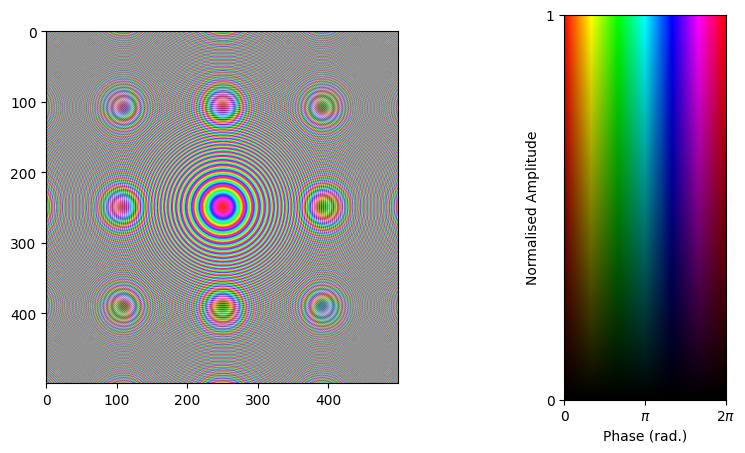

In [17]:
f = 0.06 #[m]
frenel_mask = Field(frenel_lens_mask(X,Y,wl,f))
frenel_mask.visualise()

C:\Users\elija\AppData\Local\Temp\ipykernel_11076\3006855479.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\elija\AppData\Local\Temp\ipykernel_11076\3006855479.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\elija\AppData\Local\Temp\ipykernel_11076\3006855479.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\elija\AppData\Local\Temp\ipykernel_11076\3006855479.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


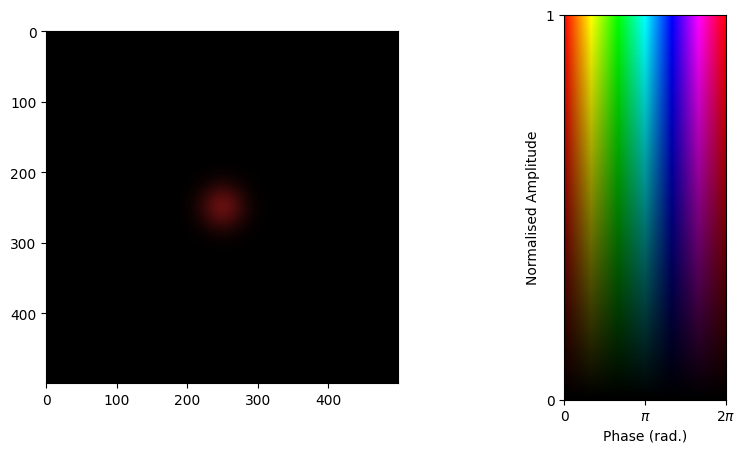

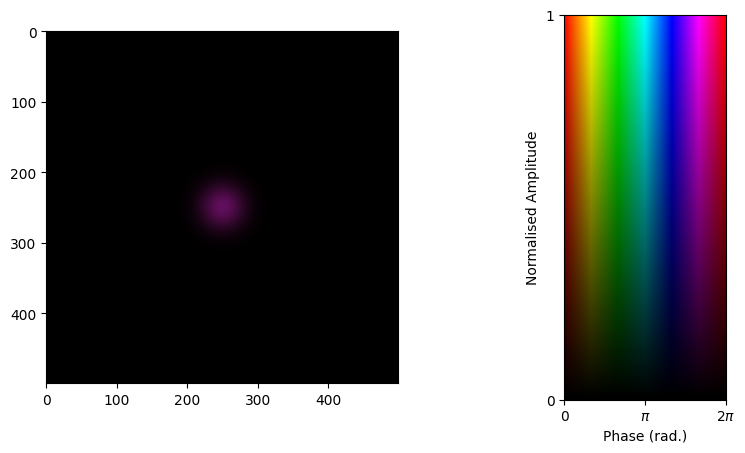

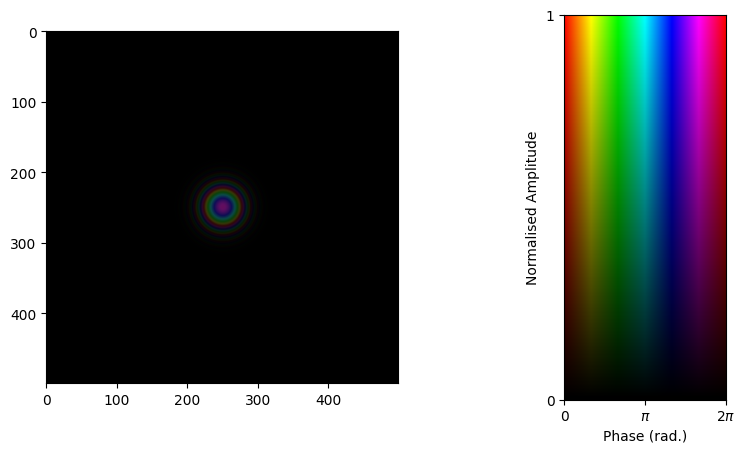

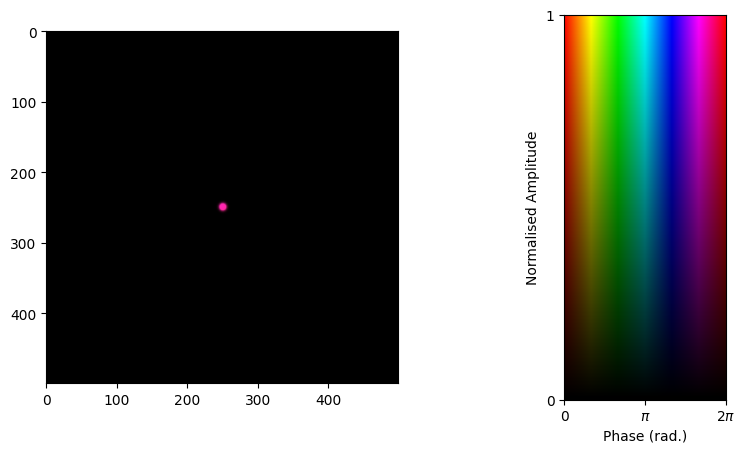

In [18]:
# Propagate a gaussian beam to the phase mask and further (Create data for model)
input_field = Field(gaussian_torch(500, 0, 0.09)).normalise().type(torch.cdouble)
input_field.visualise()
field_before_mask = prop(input_field, Kz, 0.04)
field_before_mask.visualise()
field_after_mask = frenel2d(field_before_mask,X,Y,700e-9,f)
field_after_mask.visualise()
output_field = prop(field_after_mask,Kz,0.06)
output_field.visualise()

### Form classes from these systems

In [19]:
# Make a propagation function using these fft2 functions that works on GPU
def prop(field_in, kz, distance):
    """Propagation of a 2D field using the fft2 functions."""
    field_in_ft = fft2(field_in)
    field_out_ft = field_in_ft * torch.exp(1j*kz*distance)
    field_out = ifft2(field_out_ft)
    return field_out

# Make the tilt phase mask functions that work on GPU
def tilt2d(field_in: torch.Tensor, X: torch.Tensor, Y: torch.Tensor, wl:float, alpha: float=0.0, beta: float=0.0) -> torch.Tensor:
    """Adds tilted phase to a 2D complex field."""
    tilt_phase = (-2*np.pi/wl)*(X*torch.sin(torch.deg2rad(torch.tensor(alpha))) + Y*torch.sin(torch.deg2rad(torch.tensor(beta))))
    field_out = field_in * torch.exp(1j*tilt_phase)
    #field_out = torch.abs(field_in) * torch.exp(1j*(tilt_phase+torch.angle(field_in)))
    return field_out

def tilt_phase_mask(X: torch.Tensor, Y: torch.Tensor, wl:float, alpha: float=0.0, beta: float=0.0) -> torch.Tensor:
    """Makes the tilt phase mask field, useful for plotting what the mask looks like."""
    return torch.exp(1j*(-2*np.pi/wl)*(X*torch.sin(torch.deg2rad(torch.tensor(alpha))) + Y*torch.sin(torch.deg2rad(torch.tensor(beta)))))

In [20]:
def mseloss(output, target):
    return (output-target).abs().square().sum()

In [35]:
class TiltModel(nn.Module):
    wl = 700e-9 #[m]
    pix_size = 1e-5 #[m]
    distance = 0.1 #[m]

    def __init__(self, grid_size=500, alpha=0.0, beta=0.0):
        super(TiltModel,self).__init__()
        
        self.grid_size = grid_size # Number of pixels per side of the grid
        self.grid_length = pix_size * grid_size # Length of grid in real space coords
        self.alpha = alpha
        self.beta = beta

        Nx = np.arange(-grid_size/2,grid_size/2,1)
        Ny = np.arange(-grid_size/2,grid_size/2,1)
        X,Y = np.meshgrid(Nx,Ny)
        X = torch.from_numpy(X)
        Y = torch.from_numpy(Y)

        # Make the Kx, Ky and Kz grids.
        Kx = np.ones((grid_size,grid_size))
        Ky = np.ones((grid_size,grid_size))

        for y,i in zip(np.arange(-grid_size/2,grid_size/2,1), np.arange(0,grid_size+1,1)):
            for x,j in zip(np.arange(-grid_size/2,grid_size/2,1), np.arange(0,grid_size+1,1)):
                Kx[i,j] = (2*np.pi*x)/grid_length
                Ky[i,j] = (2*np.pi*y)/grid_length
        self.Kz = torch.from_numpy(((2*np.pi/self.wl)**2 - Kx**2 - Ky**2)**0.5)#.to(device)
        
        self.Xp = X*pix_size
        self.Yp = Y*pix_size

        # Parameters
        self.z1 = nn.Parameter(data=torch.tensor([0.06], dtype=torch.float32, requires_grad=True))

    def forward(self, input_field):
        field_before_mask = prop(input_field, self.Kz, self.z1)
        field_after_mask = tilt2d(field_before_mask, self.Xp, self.Yp, self.wl, self.alpha, self.beta)
        output_field = prop(field_after_mask, self.Kz, (self.distance - self.z1))
        return output_field

In [22]:
# Form training data
field_in = Field(gaussian_torch(500, 0, 0.05)).normalise().type(torch.cdouble)
field_before_mask = prop(field_in, Kz, 0.04)
field_after_mask = tilt2d(field_before_mask,X,Y,700e-9,alpha=alpha, beta=beta)
target_field = prop(field_after_mask,Kz,0.06).to(device)
field_in = Field(gaussian_torch(500, 0, 0.05)).normalise().type(torch.cdouble).to(device)
#field_in.get_device()
target_field.is_cuda

model = TiltModel(alpha=0.7,beta=0.7).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
#next(model.parameters()).is_cuda
 
field_in_ft = fft2(field_in)
#field_in_ft.is_cuda

Kz_gpu = Kz.to(device)
#Kz_gpu.is_cuda
d = 0.1
x = prop(field_in,Kz_gpu,d)
x.is_cuda

True

In [36]:
# Form training data
field_in = Field(gaussian_torch(500, 0, 0.05)).normalise().type(torch.cdouble)
field_before_mask = prop(field_in, Kz, 0.04)
field_after_mask = tilt2d(field_before_mask,X,Y,700e-9,alpha=0.7, beta=0.7)
target_field = prop(field_after_mask,Kz,0.06)#.to(device)
field_in = Field(gaussian_torch(500, 0, 0.05)).normalise().type(torch.cdouble)#.to(device)

# Training Loop
model = TiltModel(alpha=0.7,beta=0.7)#.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

epochs = 10000

for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(field_in)

    loss = mseloss(y_pred, target_field)
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, z1: {model.z1.item()}, z2: {0.1 - model.z1.item()}")

print(f"Final Loss: {loss.item()}")
print(f"Final z1: {model.z1.item()}")
print(f"Final z2: {0.1 - model.z1.item()}")

Epoch 0, Loss: 2.0310654656439624, z1: 0.04999999701976776, z2: 0.050000002980232244
Epoch 1000, Loss: 2.0000000000188187, z1: -0.05928788334131241, z2: 0.15928788334131241
Epoch 2000, Loss: 2.0000000000188187, z1: -0.05928788334131241, z2: 0.15928788334131241
Epoch 3000, Loss: 2.0000000000188187, z1: -0.05928788334131241, z2: 0.15928788334131241
Epoch 4000, Loss: 2.0000000000188187, z1: -0.05928788334131241, z2: 0.15928788334131241
Epoch 5000, Loss: 2.0000000000188187, z1: -0.05928788334131241, z2: 0.15928788334131241
Epoch 6000, Loss: 2.0000000000188187, z1: -0.05928788334131241, z2: 0.15928788334131241
Epoch 7000, Loss: 2.0000000000188187, z1: -0.05928788334131241, z2: 0.15928788334131241


KeyboardInterrupt: 

C:\Users\elija\AppData\Local\Temp\ipykernel_11076\3006855479.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


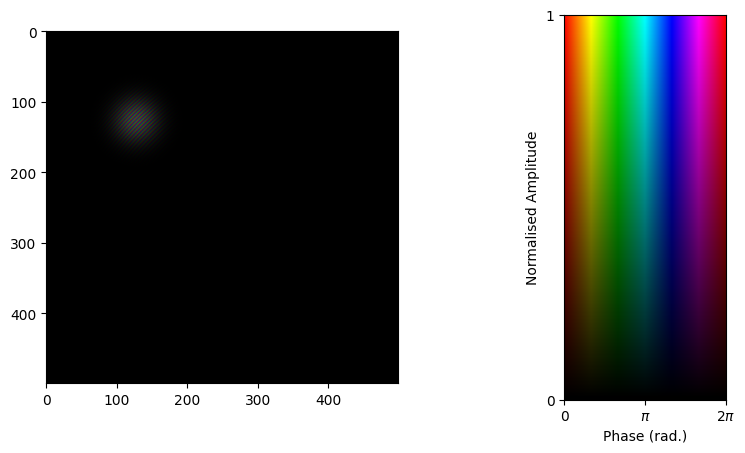

In [29]:
test = TiltModel(alpha=0.7, beta=0.7)#.to(device)
field_test = Field(gaussian_torch(500, 0, 0.05)).normalise().type(torch.cdouble)#.to(device)
Field(test.forward(field_test)).detach().visualise()
